В этом ноутбуке мы:

*   Подробнее изучим то, как устроены ошибки в моделях



# Ошибки в ансамблевых моделях


Вспомним, что в машинном обучении ошибку модели можно разложить на три составляющие:


*   смещение (bias);

*   разброс (variance);

*   неконтролируемая ошибка.


В идеальном мире все модели точно предсказывают результат и являются устойчивыми к изменению входных данных, т.е. у них малые разброс и смещение.

Однако, реальные задачи так не работают: модели с малым смещением имеют большой разброс из-за их сложности и склонности к переобучению, а модели с низким разбросом имеют большое смешение. В этих условиях наша цель — это найти "золотую середину" между этими параметрами. Иначе говоря, **нужно найти баланс между разбросом и смещением (bias-variance tradeoff).** Для того, чтобы получить этот баланс необходимо освоить инструмент, который позволяет анализировать ошибку алгоритма в зависимости от некоторого набора факторов, влияющих на итоговое качество его работы. Этот инструмент в литературе называется **bias-variance decomposition** -- разложение ошибки на смещение и разброс

Это небольшой, но важный ноутбук: в нем мы займемся построением bias-variance decomposition и научимся применять его к исследованию моделей.

Сегодня мы снова обратимся к классификации онкологичесих заболеваний. Загрузим датасет:

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

Подключим нужные библиотеки

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

Разделим выборку на трейн и тест

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)

RandomForestClassifier(n_estimators=10, random_state=2)

Проинициализируем модель случайного леса:

In [ ]:
forest = RandomForestClassifier(n_estimators=10, random_state=2)
forest.fit(X_train, y_train)

Мы подготовили процесс вычисления bias-variance decomposition и реализовали его по аналогии с лекциями.

In [ ]:
from sklearn.model_selection import ShuffleSplit, train_test_split

# Вычисляем bias-variance
def compute_bias_variance(clf, X, y):
    # Бутстрепы
    n_repeat = 40
    shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat, random_state=0)

    # Переменная для сохранения предсказания
    y_all_pred = [[] for _ in range(len(y))]

    # Обучим классификатор на каждом бутстрепе и оценим предсказания
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Обучим модель на трейне и получим значение теста
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])

        # Сохраним предсказания
        for j,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[j])

    # Вычислим смещение, разброс и ошибку.
    bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat
                for i,x in enumerate(y_all_pred)])
    var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
               for i,x in enumerate(y_all_pred)])
    error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat
            for i,x in enumerate(y_all_pred)])

    return np.sqrt(bias_sq), var, error

Отрисуем полученные результаты:

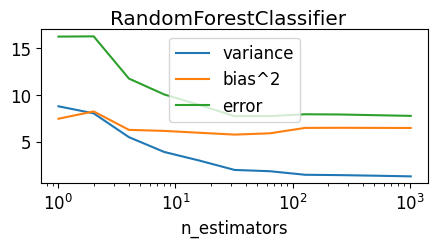

In [ ]:
def plot_bias_variance_rf(clf, X, y):
    bias_scores = []
    var_scores = []
    err_scores = []
    n_estimators= [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

    for i in n_estimators:
        b,v,e = compute_bias_variance(clf.set_params(random_state=0,n_estimators=i),X,y)
        bias_scores.append(b)
        var_scores.append(v)
        err_scores.append(e)

    plt.figure(figsize=(5,2))
    plt.rcParams.update({'font.size': 12})
    plt.suptitle(clf.__class__.__name__)
    plt.plot(n_estimators, var_scores,label ="variance" )
    plt.plot(n_estimators, np.square(bias_scores),label ="bias^2")
    plt.plot(n_estimators, err_scores,label ="error" )
    plt.xscale('log')
    plt.xlabel("n_estimators")
    plt.legend(loc="best")
    plt.show()

X, y = cancer.data, cancer.target
rf = RandomForestClassifier(random_state=0, n_estimators=512, n_jobs=-1)
plot_bias_variance_rf(rf, X, y)

Какие выводы мы можем сделать из этого графика?


1.   Разброс и ошибка уменьшаются с увеличением числа `estimators`.
2.   Смещение не подвержено влиянию количества `estimators`.
3.   Начиная с числа `estimators` равного 10^2 размер ошибки и разброса почти не меняется.



### **[Задание 1]**

В этом ноутбуке вам потребуется выполнить всего одно задание. Мы подумали, что в домашней работе и в первом семинаре заданий на код получилось достаточно, а потому мы хотим, чтобы вы происследовали алгоритм какой-нибудь алгоритм классификации (например, возьмите kNN и Voting) с помощью реализованных выше функций.

Обучите модели, постройте для них bias-variance decomposition график и сделайте выводы относительно поведения модели.

Это творческое задание, в рамках которого мы хотели бы видеть ваши креативные подходы